In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
#importing packages
import pandas as pd
import numpy as np
import tensorflow as tf
import pywt

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from skimage.restoration import denoise_wavelet
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Lambda, Bidirectional, GRU, Conv1D, TimeDistributed, RepeatVector, MaxPooling1D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [10]:
#setting figure size
rcParams['figure.figsize'] = 20,10

#for normalizing data
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('/content/drive/My Drive/DATA/TSLA_recent.csv')

#df['Date'] = df[['Date', 'Time']].apply(lambda x: '-'.join(x), axis=1)
#print the head
df

UnicodeDecodeError: ignored

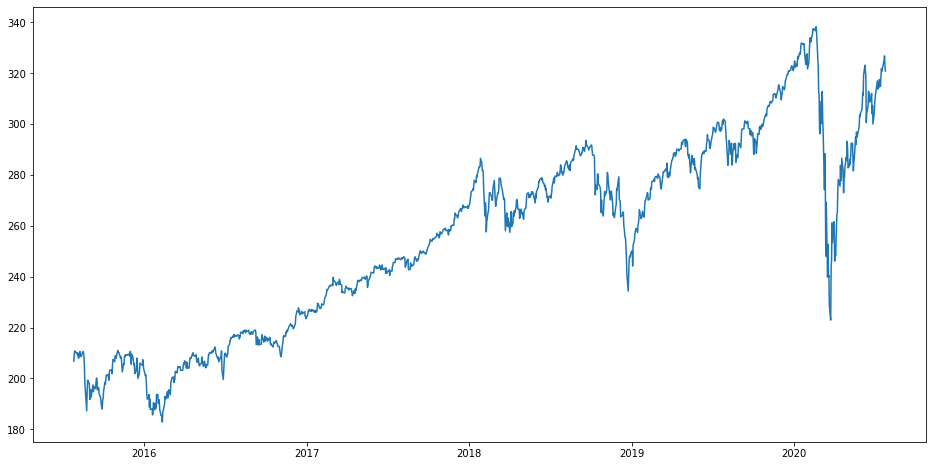

In [ ]:
#setting index as date
#df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df['Date'] = pd.to_datetime(df.Date)
df.index = df['Date']
#df = df[df['Date'] < '2020-01-01']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

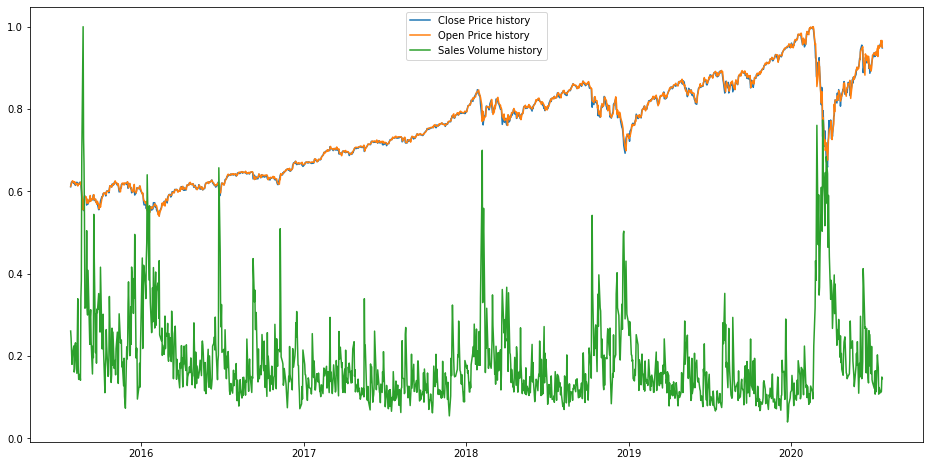

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(df['Close']/np.max(df['Close']), label='Close Price history')
plt.plot(df['Open']/np.max(df['Open']), label='Open Price history')
plt.plot(df['Volume']/np.max(df['Volume']), label='Sales Volume history')
plt.legend()

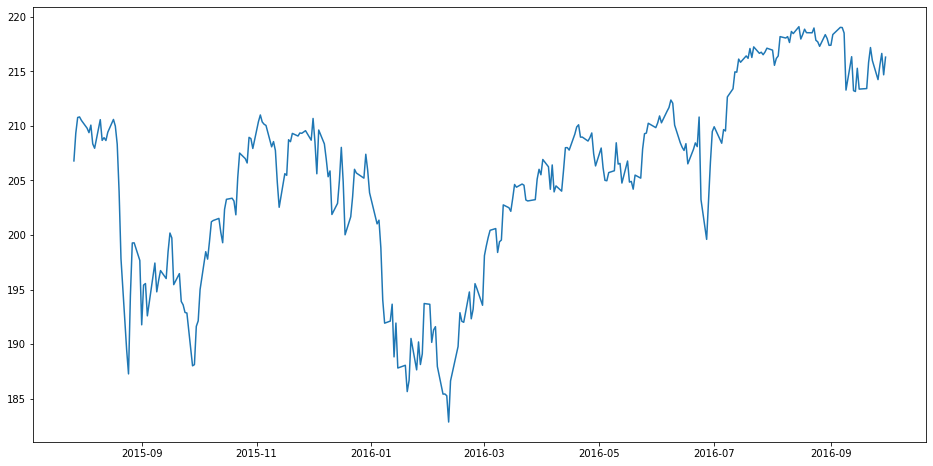

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(df['Close'][0:300], label='Close Price history')

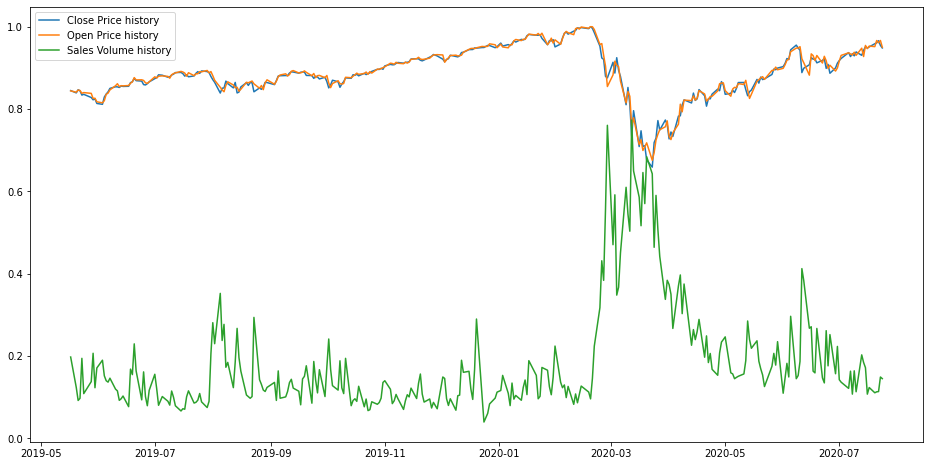

In [ ]:
#setting index as date
#df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
# df['Date'] = pd.to_datetime(df.Date)
# df.index = df['Date']
#df = df[df['Date'] < '2020-01-01']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'][-300:]/np.max(df['Close']), label='Close Price history')
plt.plot(df['Open'][-300:]/np.max(df['Open']), label='Open Price history')
plt.plot(df['Volume'][-300:]/np.max(df['Volume']), label='Sales Volume history')
plt.legend()

In [ ]:
#creating dataframe
T = 30 #training period
T_pred = 30 #prediction period

data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values
dataset_orig = dataset.copy()

# #FFT on dataset
# n = len(dataset)
# dataset= np.fft.fft(dataset,n) 
# dataset = dataset* np.conj(dataset) / n
# dataset = np.real(dataset)
# dataset = dataset[:,0]
# dataset = dataset.reshape(-1,1)

# DWT on dataset
dataset = denoise_wavelet(dataset.astype('float'), wavelet='Sym20', mode='soft', method='BayesShrink', rescale_sigma=True)

split_constant = int(0.2*len(dataset)/T_pred)

train = dataset[:-T_pred*split_constant,:]
valid = dataset_orig[-T_pred*split_constant:,:]

dataset.shape, train.shape, valid.shape, split_constant

/usr/local/lib/python3.6/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 1 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


((1259, 1), (1019, 1), (240, 1), 8)

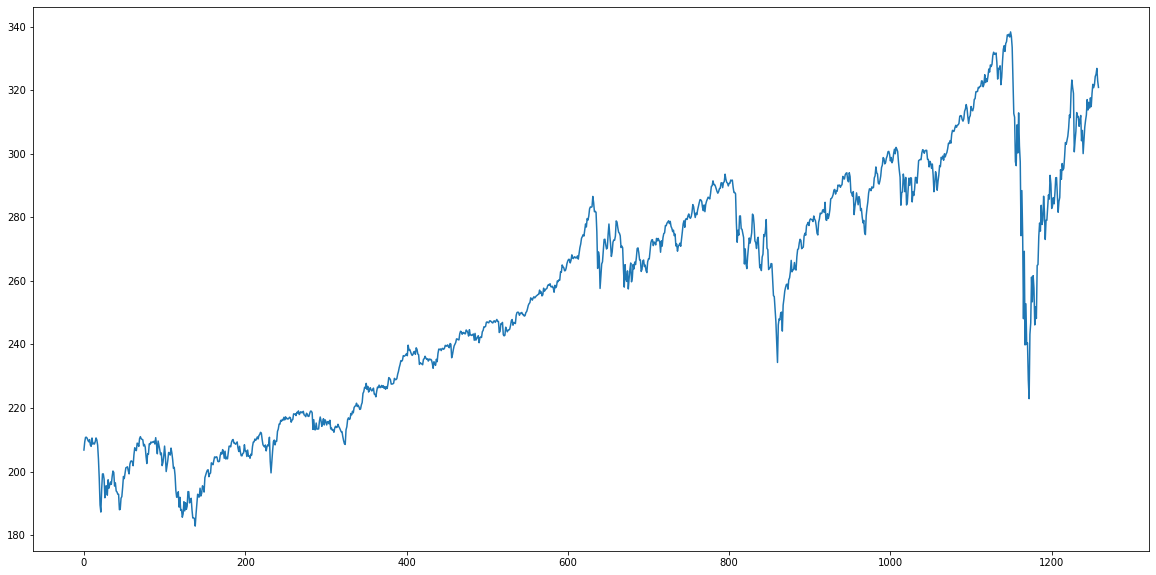

In [ ]:
plt.plot(dataset)

In [ ]:
#converting dataset into x_train and y_train
# T = 30 #training period
# T_pred = T
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(T,len(train)-T_pred):
    x_train.append(scaled_data[i-T:i,:])
    y_train.append(scaled_data[i:i+T_pred,:])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
#y_train = np.reshape(y_train, (y_train.shape[0],y_train.shape[1],1))
print(x_train.shape, y_train.shape)


(959, 30, 1) (959, 30, 1)


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 28, 64)            256       
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 14, 64)            0         
_________________________________________________________________
lstm_48 (LSTM)               (None, 14, 200)           212000    
_________________________________________________________________
dropout_24 (Dropout)         (None, 14, 200)           0         
_________________________________________________________________
lstm_49 (LSTM)               (None, 200)               320800    
_________________________________________________________________
repeat_vector_12 (RepeatVect (None, 30, 200)           0         
_________________________________________________________________
lstm_50 (LSTM)               (None, 30, 200)         

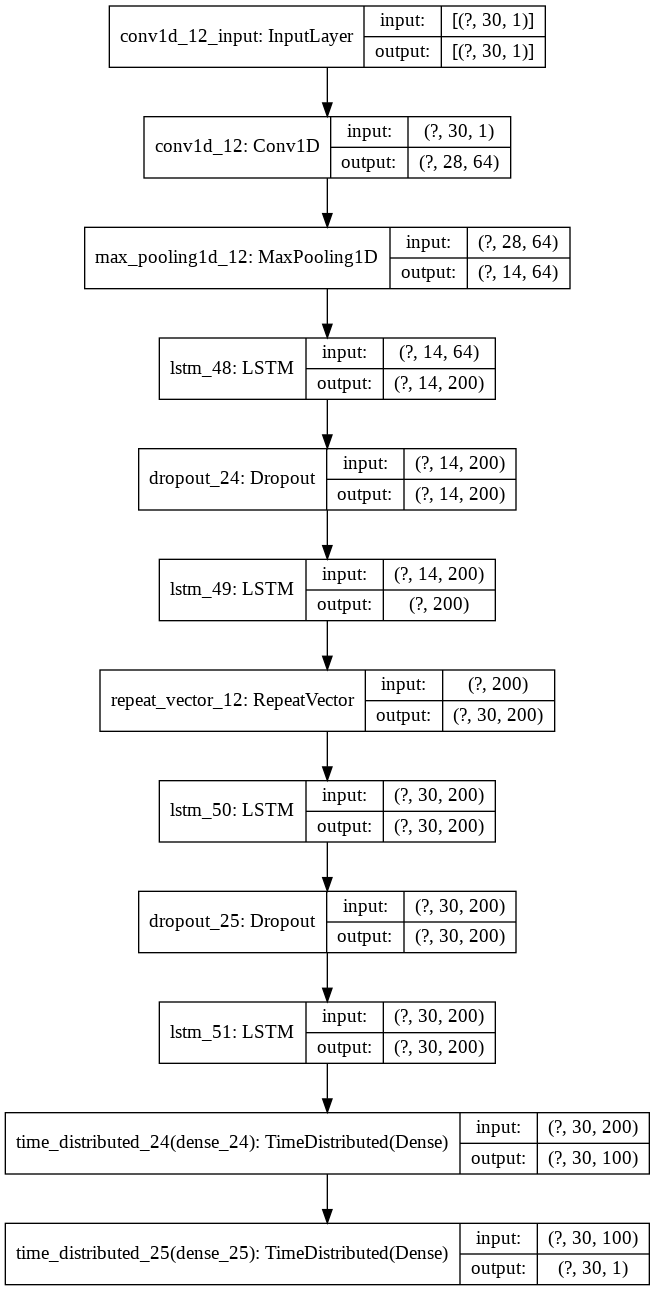

In [ ]:
# create and fit the LSTM network
model_name = '30_30_DWT_Encoder_Decoder_SPY_JULY15_JAN20'
weight_save_path = '/content/drive/My Drive/LSTM/Results/'

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(T,1)))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(200, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(200, activation='tanh'))
model.add(RepeatVector(T_pred))
model.add(LSTM(200, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(200, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(100)))
model.add(TimeDistributed(Dense(1)))

model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001), metrics=['mae'])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# create and fit the LSTM network
model_name = '4-1_DWT_SPY_JULY15_JAN20'
weight_save_path = '/content/drive/My Drive/LSTM/Results/'

model = Sequential()
model.add(Conv1D(filters=300, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape = [T,1]))
model.add(BatchNormalization())
model.add(LSTM(units=300, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(units=200, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=200, activation='tanh', return_sequences= True))
model.add(Dropout(0.1))
model.add(LSTM(units=150, activation='tanh', return_sequences= True))
model.add(Dropout(0.1))
model.add(LSTM(units=150, activation='tanh'))
model.add(Dense(100))
model.add(Dropout(0.2))
model.add(Dense(20))
model.add(Dense(T_pred))
#model.add(RepeatVector(T_pred))
#model.add(Lambda(lambda x: x*200))


model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mae'])
model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 30, 300)           1800      
_________________________________________________________________
batch_normalization_20 (Batc (None, 30, 300)           1200      
_________________________________________________________________
lstm_50 (LSTM)               (None, 30, 300)           721200    
_________________________________________________________________
dropout_50 (Dropout)         (None, 30, 300)           0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 30, 300)           1200      
_________________________________________________________________
lstm_51 (LSTM)               (None, 30, 200)           400800    
_________________________________________________________________
dropout_51 (Dropout)         (None, 30, 200)         

In [ ]:
#callbacks
lr_schedule = tf.keras.callbacks.LearningRateScheduler( lambda epoch: 1e-8 * 10**(epoch/ 20))
checkpoint = ModelCheckpoint(weight_save_path+model_name+'.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, )
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80, mode='min',restore_best_weights=True)

In [ ]:
import time
start = time.time()
history = model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=[lr_schedule])
end = time.time()
print('Run time: {}'.format((end-start)/60))

Epoch 1/100
30/30 [==============================] - 0s 13ms/step - loss: 0.2023 - mae: 0.4030
Epoch 2/100
30/30 [==============================] - 0s 10ms/step - loss: 0.2024 - mae: 0.4030
Epoch 3/100
30/30 [==============================] - 0s 10ms/step - loss: 0.2023 - mae: 0.4030
Epoch 4/100
30/30 [==============================] - 0s 10ms/step - loss: 0.2023 - mae: 0.4029
Epoch 5/100
30/30 [==============================] - 0s 10ms/step - loss: 0.2022 - mae: 0.4029
Epoch 6/100
30/30 [==============================] - 0s 11ms/step - loss: 0.2021 - mae: 0.4028
Epoch 7/100
30/30 [==============================] - 0s 10ms/step - loss: 0.2021 - mae: 0.4027
Epoch 8/100
30/30 [==============================] - 0s 11ms/step - loss: 0.2019 - mae: 0.4026
Epoch 9/100
30/30 [==============================] - 0s 11ms/step - loss: 0.2018 - mae: 0.4025
Epoch 10/100
30/30 [==============================] - 0s 10ms/step - loss: 0.2018 - mae: 0.4024
Epoch 11/100
30/30 [=============================

(1e-08, 0.01, 0.0, 1.0)

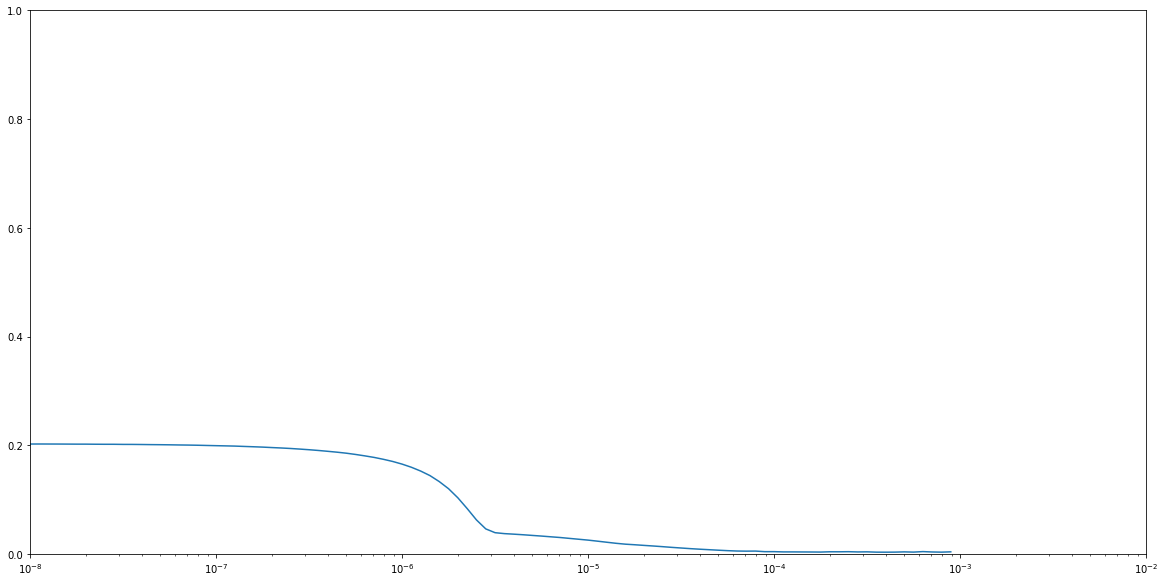

In [ ]:
#plotting loss per epoch against learning rate
lrs = 1e-8 * (10 ** (np.arange(100)/20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-2, 0, 1])
#use this to choose the optimum lr and run the NN for 500 epochs

In [ ]:
class stop_training(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if (logs.get('loss')<0.0001):
      print("Stopping training")
      self.model.stop_training = True

stop_training = stop_training()
model.compile(loss='mse', optimizer=Adam(lr=1e-4), metrics=['mae'])
import time
start = time.time()
history = model.fit(x_train, y_train, epochs=1000, batch_size=32, callbacks=[checkpoint, stop_training], validation_split=0.1)
end = time.time()
print('Run time: {}'.format((end-start)/60))

Epoch 1/1000
27/27 [==============================] - 2s 57ms/step - loss: 0.0697 - mae: 0.2054 - val_loss: 0.0739 - val_mae: 0.2261
Epoch 2/1000
27/27 [==============================] - 0s 14ms/step - loss: 0.0208 - mae: 0.0988 - val_loss: 0.0447 - val_mae: 0.1546
Epoch 3/1000
27/27 [==============================] - 0s 14ms/step - loss: 0.0143 - mae: 0.0785 - val_loss: 0.0278 - val_mae: 0.1063
Epoch 4/1000
27/27 [==============================] - 0s 13ms/step - loss: 0.0114 - mae: 0.0709 - val_loss: 0.0239 - val_mae: 0.1031
Epoch 5/1000
27/27 [==============================] - 0s 13ms/step - loss: 0.0095 - mae: 0.0647 - val_loss: 0.0174 - val_mae: 0.0811
Epoch 6/1000
27/27 [==============================] - 0s 13ms/step - loss: 0.0080 - mae: 0.0600 - val_loss: 0.0138 - val_mae: 0.0738
Epoch 7/1000
27/27 [==============================] - 0s 13ms/step - loss: 0.0070 - mae: 0.0570 - val_loss: 0.0120 - val_mae: 0.0730
Epoch 8/1000
27/27 [==============================] - 0s 12ms/step - 

No handles with labels found to put in legend.


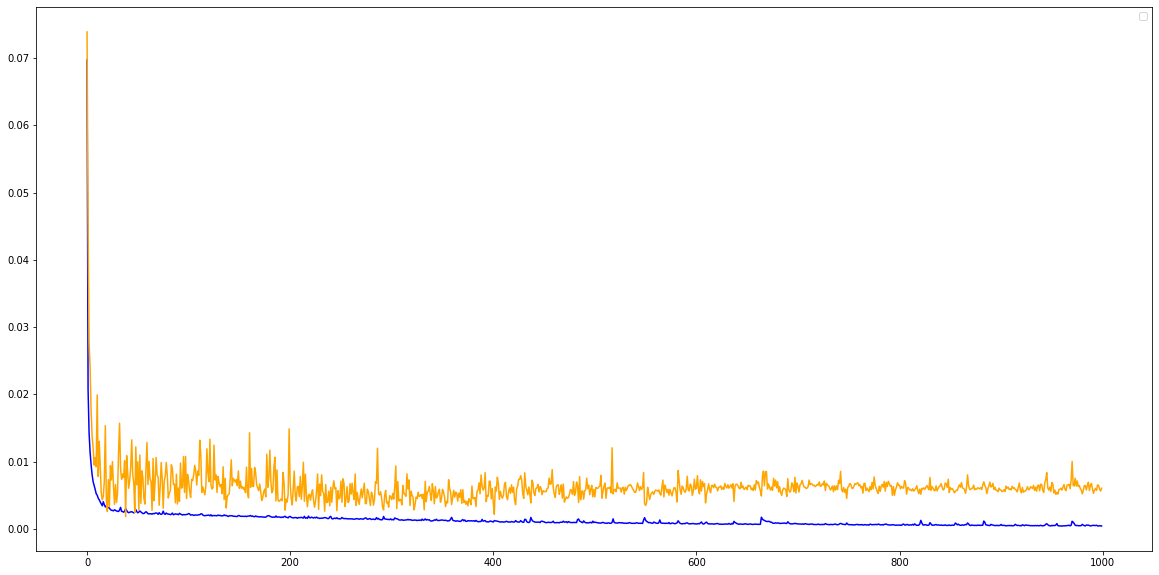

In [ ]:
#Plotting the loss
plt.plot(history.history['loss'], color='blue')
plt.plot(history.history['val_loss'], color='orange')
plt.legend()

In [ ]:
model.load_weights(weight_save_path+model_name+'.h5')


In [ ]:
#Predictions on test set
closing_price = np.zeros((len(valid)))
X_test = dataset[-(len(valid)+T):]

for i in range(0,len(valid),T_pred):
  X_test_scaled = scaler.transform(X_test[i:i+T,:])
  X_test_scaled = X_test_scaled.reshape(1,-1,1)
  pred = model.predict(X_test_scaled)
  closing_price[i:i+T_pred] = np.squeeze(pred)

closing_price = closing_price.reshape(-1,1)
closing_price = scaler.inverse_transform(closing_price)

closing_price.shape

(240, 1)

In [ ]:
print(closing_price.shape)
print(X_test.shape)
print(valid.shape)

(240, 1)
(270, 1)
(240, 1)


In [ ]:
#rms error
rms = np.sqrt(np.mean(np.power((valid- closing_price),2)))
std = np.std(valid)
print('RMS error of the predictions on validation data: {:.2f}'.format(rms))
print('Standard deviation of the validation data: {:.2f}'.format(std))


RMS error of the predictions on validation data: 23.28
Standard deviation of the validation data: 21.80


In [ ]:
#Mean Absolute Percentage Error(MAPE)
MAPE = np.sum(np.abs((valid - closing_price)/valid)) / len(valid)
print('MAPE on validation data: {:.2f}'.format(MAPE),'\n')

#Correlation Coefficient R
mean_actual = np.mean(valid)
mean_predicted = np.mean(closing_price)
num = np.sum((valid - mean_actual)*(closing_price - mean_predicted)) 
den = np.sqrt(np.sum(((valid - mean_actual)**2))*np.sum(((closing_price - mean_predicted)**2)))
R = num/den
print('R of validation data: {:.2f}'.format(R), '\n')

#Theil's Inequality Coefficient Theil_U
num = np.sqrt((1/len(valid))*np.sum((valid - closing_price)**2))
den = np.sqrt((1/len(valid))*np.sum(valid**2)) + np.sqrt((1/len(valid))*np.sum(closing_price**2))
Theil_U = num/den
print('Theil U of validation data: {:.2f}'.format(Theil_U))


MAPE on validation data: 0.06 

R of validation data: 0.36 

Theil U of validation data: 0.04


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


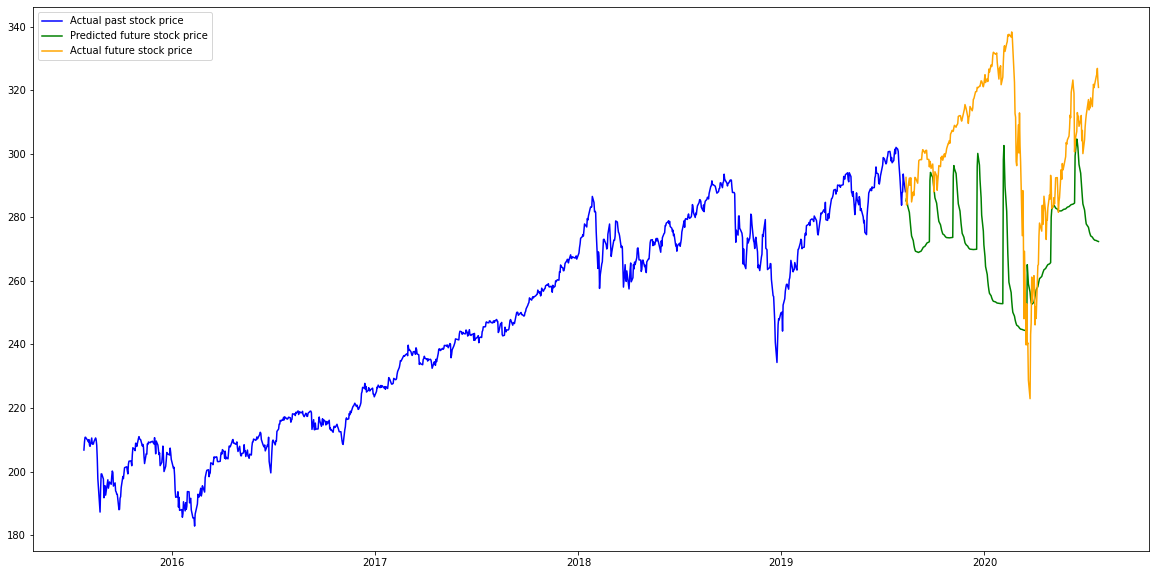

In [ ]:
#for plotting
train = new_data[:len(train)]
#train_pred = new_data[T:450]
valid = new_data[len(train):]
#train_pred['Predictions'] = closing_price_train
valid['Predictions'] = closing_price.reshape(-1,1)
plt.plot(train['Close'], color='blue', label='Actual past stock price')
#plt.plot(train_pred['Predictions'], color='red', label='Predicted past stock price')
#plt.plot(valid['Predictions'], label='Predicted stock price')
plt.plot(valid['Predictions'], color = 'green', label='Predicted future stock price')
plt.plot(valid['Close'], color = 'orange', label='Actual future stock price')
plt.legend()

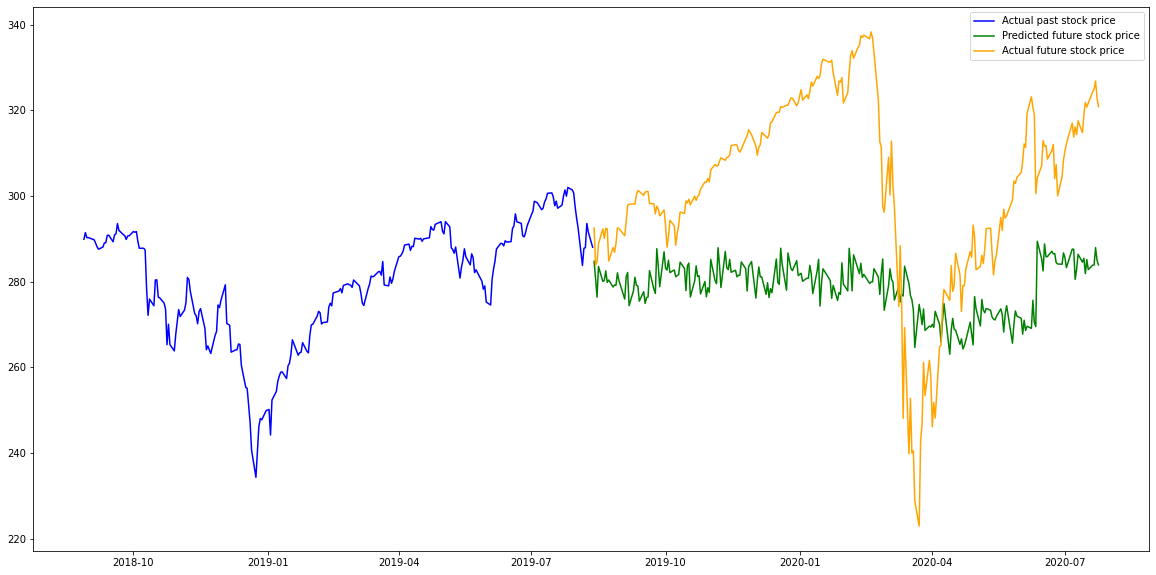

In [ ]:
plt.plot(train['Close'][len(train)-len(valid):], color='blue', label='Actual past stock price')
#plt.plot(train_pred['Predictions'], color='red', label='Predicted past stock price')
#plt.plot(valid['Predictions'], label='Predicted stock price')
plt.plot(valid['Predictions'], color = 'green', label='Predicted future stock price')
plt.plot(valid['Close'], color = 'orange', label='Actual future stock price')
plt.legend()

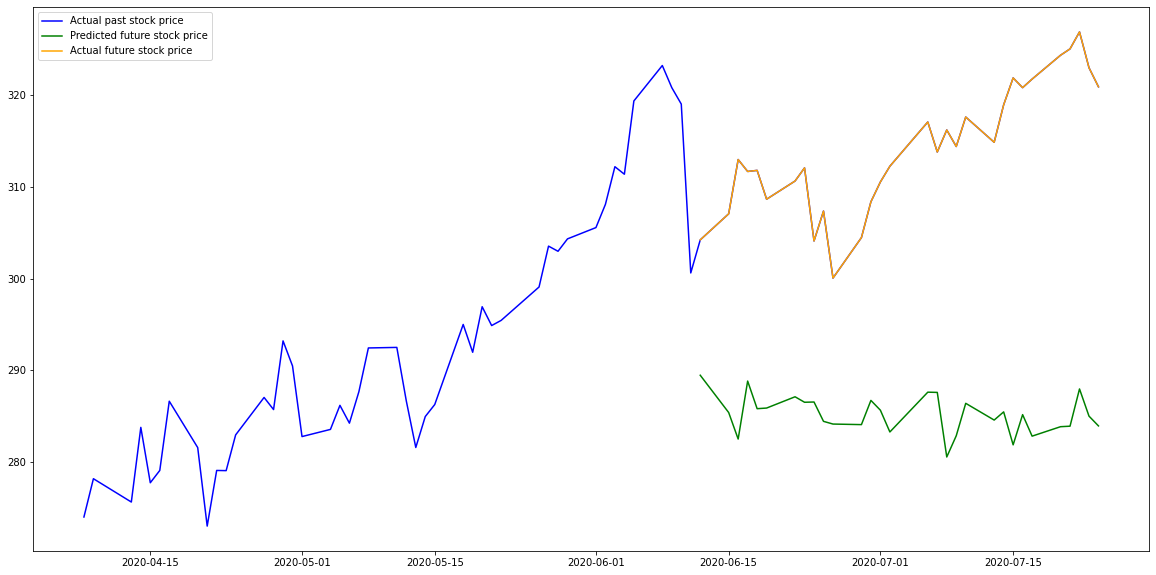

In [ ]:
#plt.plot(train['Close'][len(train)-len(valid):], color='blue', label='Actual past stock price')
#plt.plot(train_pred['Predictions'], color='red', label='Predicted past stock price')
#plt.plot(valid['Predictions'], label='Predicted stock price')
plt.plot(valid['Close'][-(T_pred+T):], color = 'blue', label='Actual past stock price')
plt.plot(valid['Predictions'][-T_pred:], color = 'green', label='Predicted future stock price')
plt.plot(valid['Close'][-T_pred:], color = 'orange', label='Actual future stock price')
plt.legend()

In [ ]:
rms1=np.sqrt(np.mean(np.power((valid['Predictions'][-T_pred:] - valid['Close'][-T_pred:]),2)))
print('RMS error of final prediction: {:.2f}'.format(rms1))

RMS error of final prediction: 31.55


In [ ]:
inputs = new_data[len(new_data) - len(valid) - T:len(new_data) - len(valid)].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
X_test = np.reshape(inputs, (1,-1,1))
X_test.shape
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
closing_price.shape

In [ ]:
#Predictions on test set
closing_price = np.zeros((len(valid)))
X_test = []
for pred in range(len(closing_price)):
  #Single valued output
  if pred<T:
    X_test = new_data[len(train) - T + pred:len(train)].values
    X_test = X_test.reshape(-1,1)
    X_test = scaler.transform(X_test)
    if pred>0:
      X_test = np.concatenate((X_test, closing_price[:pred]), axis = None)  
  if pred>=T:
    X_test = closing_price[pred - T:pred]
  X_test = np.array(X_test)
  X_test = X_test.reshape(-1,1)
  #X_test  = scaler.transform(X_test)

  X_test = np.reshape(X_test, (X_test.shape[1],X_test.shape[0],1))
  closing_price[pred] = model.predict(X_test)
  #closing_price[pred] = scaler.inverse_transform(closing_price[pred]) 

closing_price = closing_price.reshape(-1,1)
closing_price = scaler.inverse_transform(closing_price)
closing_price.shape #single valued output prediction

In [ ]:
print(closing_price.shape)
print(X_test.shape)
print(x_train.shape)
print(y_train.shape)

(292, 1)
(1, 90, 1)
(710, 90, 1)
(710,)


In [ ]:
closing_price


In [ ]:
#rms error
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms
#np.mean(np.abs(valid - closing_price))

Close          163.078557
Predictions    158.291392
dtype: float64

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


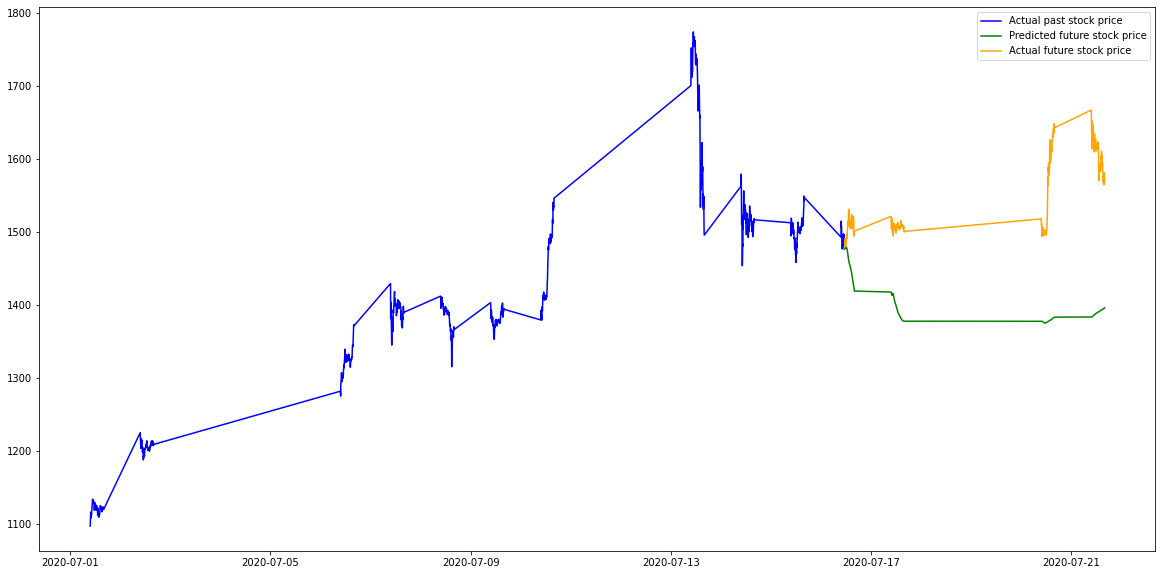

In [ ]:
#for plotting
train = new_data[:800]
#train_pred = new_data[T:450]
valid = new_data[800:]
#train_pred['Predictions'] = closing_price_train
valid['Predictions'] = closing_price
plt.plot(train['Close'], color='blue', label='Actual past stock price')
#plt.plot(train_pred['Predictions'], color='red', label='Predicted past stock price')
#plt.plot(valid['Predictions'], label='Predicted stock price')
plt.plot(valid['Predictions'], color = 'green', label='Predicted future stock price')
plt.plot(valid['Close'], color = 'orange', label='Actual future stock price')
plt.legend()



In [ ]:
valid

,Close,Predictions
Date,,
2019-11-01,1273.74,1244.864561
2019-11-04,1291.37,1235.571965
2019-11-05,1292.03,1225.102388
2019-11-06,1291.8,1212.246379
2019-11-07,1308.86,1201.619072
...,...,...
2020-07-14,1520.58,1195.485181
2020-07-15,1513.64,1195.874253
2020-07-16,1518,1196.312305


In [ ]:
valid.to_csv('/content/drive/My Drive/Covid 19 part(2)/Results_1/TESLA_Predicted_vs_Actual_Stock_Prices_JULY.csv')

In [ ]:
#Prediction for 22nd July, 2017
inputs = new_data[len(new_data) - T:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = inputs
X_test = X_test.reshape(1,T,1)

closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
print('Price on 22nd July : {}'.format(closing_price[0][0]))

Price on 22nd July : 1605.862060546875


In [ ]:
#learning rate decay(picking optimum learning rate)
lr_schedule = tf.keras.callbacks.LearningRateScheduler( lambda epoch: 1e-8 * 10**(epoch/ 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

In [ ]:
#plotting loss per epoch against learning rate
lrs = 1e-8 * (10 ** (np.arange(100)/20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 300])
#use this to choose the optimum lr and run the NN for 500 epochs

In [ ]:
#Conv1D
tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape = [None,1])

In [ ]:
#Converting the data in a df to float
df = df.astype('float64')

In [ ]:
#concatenating two colums
data['date_time'] = data['date'].str.cat(data['time'], sep=' ')

In [ ]:
#getting daily data from minute/hour wise data
df = df.resample('D').mean() # if we want mean of time data
df = df.resample('D').sum() # if we want sum of time data

In [ ]:
#evaluate model for multi-step LSTM
def evaluate_model(y_true, y_predicted):
  scores = []

  #calculating score for each day
  for i in range(y_true.shape[1]):
    mse = mean_squared_error(y_true[:, i], y_predicted[:, i])
    rmse = np.sqrt(mse)
    scores.append(rmse)

  #calculating score for whole prediction
  total_score = 0
  for row in range(y_true.shape[0]):
    for col in range(y_predicted.shape[1]):
      total_score = total_score + (y_true[row,col] - y_predicted[row,col])**2
  total_score = np.sqrt(total_score/(y_true.shape[0]*y_predicted.shape[1]))

  return total_ score, scores

evaluate_model(y_true, y_pred)
np.std(y_true[0])



In [ ]:
data = pd.read_csv('/content/drive/My Drive/Covid 19 part(2)/LSTM/AAPL_JAN18_JULY20.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-19,178.610001,179.580002,177.410004,178.460007,172.341141,32425100
1,2018-01-22,177.300003,177.779999,176.600006,177.000000,170.931198,27108600
2,2018-01-23,177.300003,179.440002,176.820007,177.039993,170.969803,32689100
3,2018-01-24,177.250000,177.300003,173.199997,174.220001,168.246521,51105100
4,2018-01-25,174.509995,174.949997,170.529999,171.110001,165.243134,41529000
...,...,...,...,...,...,...,...
622,2020-07-10,381.339996,383.920013,378.820007,383.679993,383.679993,22564300
623,2020-07-13,389.059998,399.820007,381.029999,381.910004,381.910004,47912300
624,2020-07-14,379.359985,389.019989,375.510010,388.230011,388.230011,42747300
625,2020-07-15,395.959991,396.989990,385.959991,390.899994,390.899994,38299500


In [ ]:
data_training = data[data['Date'] < '2019-12-31'].copy()
data_training

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-19,178.610001,179.580002,177.410004,178.460007,172.341141,32425100
1,2018-01-22,177.300003,177.779999,176.600006,177.000000,170.931198,27108600
2,2018-01-23,177.300003,179.440002,176.820007,177.039993,170.969803,32689100
3,2018-01-24,177.250000,177.300003,173.199997,174.220001,168.246521,51105100
4,2018-01-25,174.509995,174.949997,170.529999,171.110001,165.243134,41529000
...,...,...,...,...,...,...,...
485,2019-12-23,280.529999,284.250000,280.369995,284.000000,282.562683,24643000
486,2019-12-24,284.690002,284.890015,282.920013,284.269989,282.831299,12119700
487,2019-12-26,284.820007,289.980011,284.700012,289.910004,288.442780,23280300
488,2019-12-27,291.119995,293.970001,288.119995,289.799988,288.333313,36566500


In [ ]:
data_testing = data[data['Date'] >= '2019-12-31'].copy()
data_testing

,Date,Open,High,Low,Close,Adj Close,Volume
490,2019-12-31,289.929993,293.679993,289.519989,293.649994,292.163818,25201400
491,2020-01-02,296.239990,300.600006,295.190002,300.350006,298.829956,33870100
492,2020-01-03,297.149994,300.579987,296.500000,297.429993,295.924713,36580700
493,2020-01-06,293.790009,299.959991,292.750000,299.799988,298.282715,29596800
494,2020-01-07,299.839996,300.899994,297.480011,298.390015,296.879883,27218000
...,...,...,...,...,...,...,...
622,2020-07-10,381.339996,383.920013,378.820007,383.679993,383.679993,22564300
623,2020-07-13,389.059998,399.820007,381.029999,381.910004,381.910004,47912300
624,2020-07-14,379.359985,389.019989,375.510010,388.230011,388.230011,42747300
625,2020-07-15,395.959991,396.989990,385.959991,390.899994,390.899994,38299500


In [ ]:
training_data = data_training.drop(['Date', 'Adj Close'], axis=1)
training_data

,Open,High,Low,Close,Volume
0,178.610001,179.580002,177.410004,178.460007,32425100
1,177.300003,177.779999,176.600006,177.000000,27108600
2,177.300003,179.440002,176.820007,177.039993,32689100
3,177.250000,177.300003,173.199997,174.220001,51105100
4,174.509995,174.949997,170.529999,171.110001,41529000
...,...,...,...,...,...
485,280.529999,284.250000,280.369995,284.000000,24643000
486,284.690002,284.890015,282.920013,284.269989,12119700
487,284.820007,289.980011,284.700012,289.910004,23280300
488,291.119995,293.970001,288.119995,289.799988,36566500


In [ ]:
scalar = MinMaxScaler()
training_data = scalar.fit_transform(training_data)
training_data.shape

(490, 5)

In [ ]:
x_train = []
y_train = []

T = 60
for i in range(T, training_data.shape[0]):
  x_train.append(training_data[i-T:i])
  y_train.append(training_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(430, 60, 5)
(430,)


In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, activation='tanh', input_shape=(x_train.shape[1],5)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, activation='tanh'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 50)            11200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 91,901
Trainable params: 91,901
Non-trainable params: 0
__________________________________________________

In [ ]:
import time
start = time.time()
model.fit(x_train, y_train, epochs=50, batch_size=8)
end = time.time()
print('Run time: {}'.format((end-start)/60))

Epoch 1/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0159
Epoch 2/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0041
Epoch 3/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0029
Epoch 4/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0030
Epoch 5/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0028
Epoch 6/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0028
Epoch 7/50
54/54 [==============================] - 2s 41ms/step - loss: 0.0024
Epoch 8/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0024
Epoch 9/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0038
Epoch 10/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0022
Epoch 11/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0019
Epoch 12/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0020
Epoch 13/50
54/54 [==================

In [ ]:
past_T_days = data_training.tail(T)

df = past_T_days.append(data_testing, ignore_index = True)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-04,225.639999,227.490005,223.889999,227.009995,225.185043,34619700
1,2019-10-07,226.270004,229.929993,225.839996,227.059998,225.234634,30576500
2,2019-10-08,225.820007,228.059998,224.330002,224.399994,222.596024,27955000
3,2019-10-09,227.029999,227.789993,225.639999,227.029999,225.204895,18692600
4,2019-10-10,227.929993,230.440002,227.300003,230.089996,228.240280,28253400
...,...,...,...,...,...,...,...
192,2020-07-10,381.339996,383.920013,378.820007,383.679993,383.679993,22564300
193,2020-07-13,389.059998,399.820007,381.029999,381.910004,381.910004,47912300
194,2020-07-14,379.359985,389.019989,375.510010,388.230011,388.230011,42747300
195,2020-07-15,395.959991,396.989990,385.959991,390.899994,390.899994,38299500


In [ ]:
df = df.drop(['Date', 'Adj Close'], axis=1)
df

,Open,High,Low,Close,Volume
0,225.639999,227.490005,223.889999,227.009995,34619700
1,226.270004,229.929993,225.839996,227.059998,30576500
2,225.820007,228.059998,224.330002,224.399994,27955000
3,227.029999,227.789993,225.639999,227.029999,18692600
4,227.929993,230.440002,227.300003,230.089996,28253400
...,...,...,...,...,...
192,381.339996,383.920013,378.820007,383.679993,22564300
193,389.059998,399.820007,381.029999,381.910004,47912300
194,379.359985,389.019989,375.510010,388.230011,42747300
195,395.959991,396.989990,385.959991,390.899994,38299500


In [ ]:
inputs = scalar.transform(df)
inputs.shape

(197, 5)